# Classifying Indian denomiation

## Importing libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Setting the path to the dataset

In [2]:
import pathlib
data_dir = '/home/glitch101/Downloads/CURRENCY_DATASET'
data_dir  = pathlib.Path(data_dir)

#### Checking the number of images in the dataset

In [3]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

400


### Samples of each class

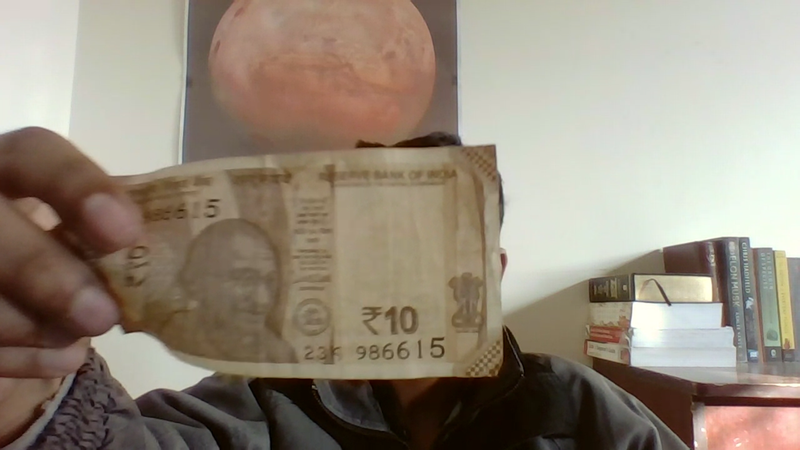

In [4]:
ten = list(data_dir.glob('10/*'))
PIL.Image.open(str(ten[0]))

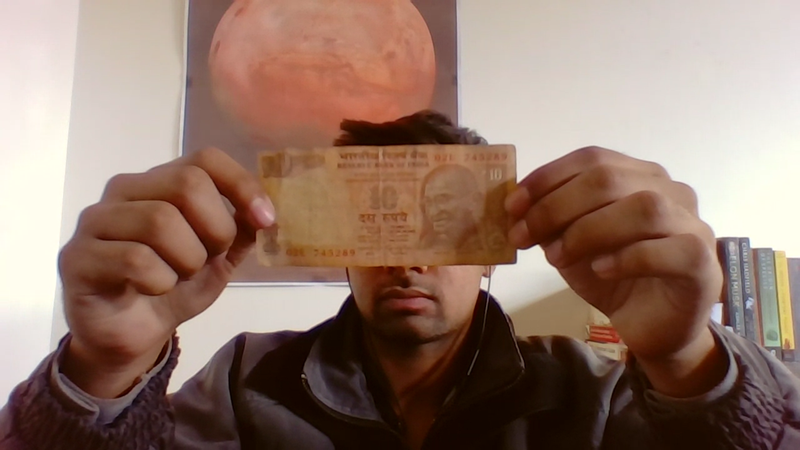

In [5]:
PIL.Image.open(str(ten[1]))

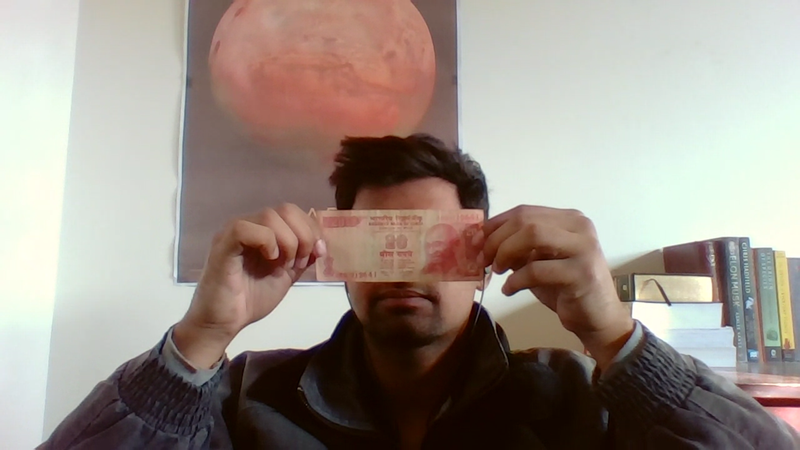

In [6]:
twenty = list(data_dir.glob('20/*'))
PIL.Image.open(str(twenty[0]))

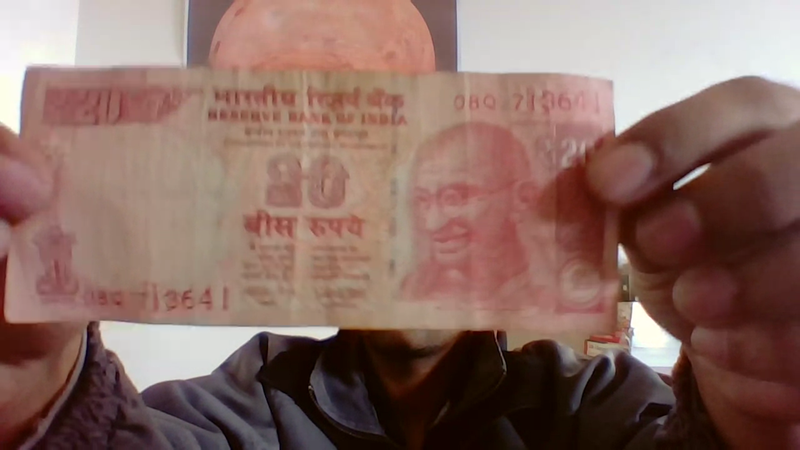

In [7]:
PIL.Image.open(str(twenty[1]))

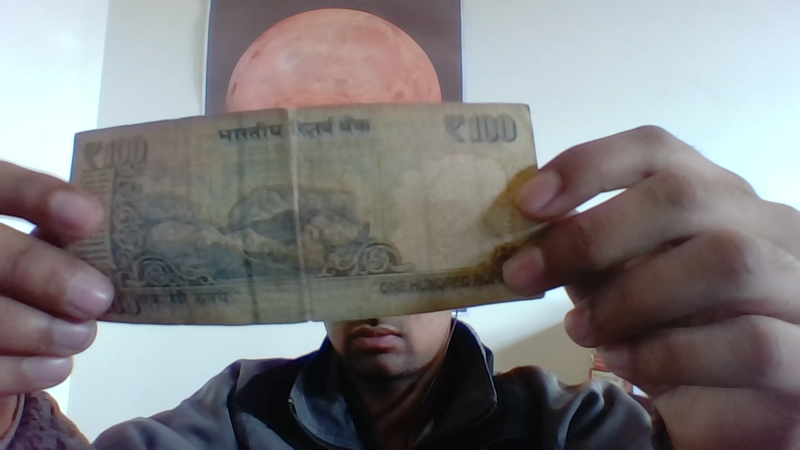

In [8]:
hundred = list(data_dir.glob('100/*'))
PIL.Image.open(str(hundred[0]))

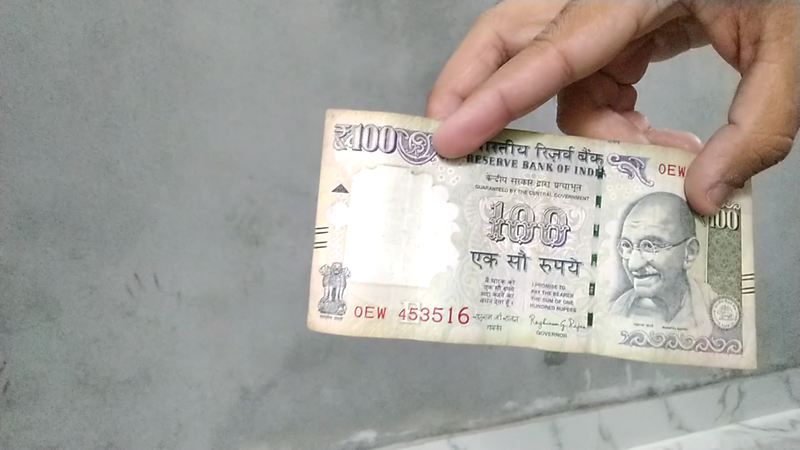

In [9]:
PIL.Image.open(str(hundred[1]))

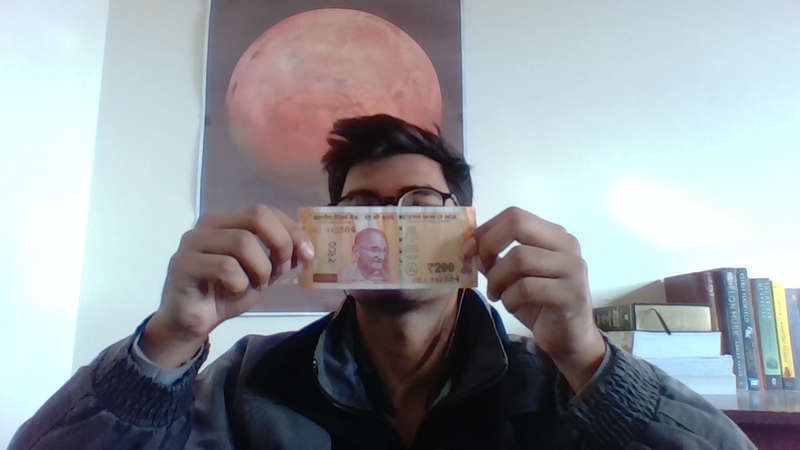

In [10]:
two_hundred = list(data_dir.glob('200/*'))
PIL.Image.open(str(two_hundred[0]))

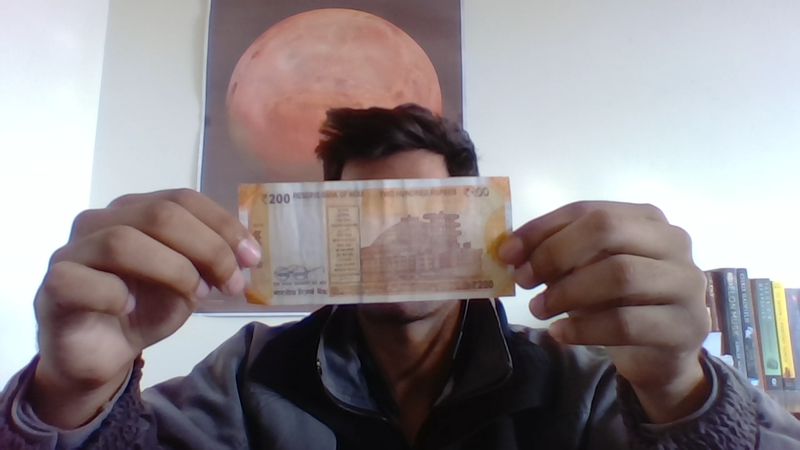

In [11]:
PIL.Image.open(str(two_hundred[1]))

### Defining some parameters for the loader

In [12]:
batch_size = 32
img_height = 180
img_width = 180

### I have used a 80-20 ratio for training and testing images

In [13]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 556 files belonging to 4 classes.
Using 445 files for training.


In [14]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 556 files belonging to 4 classes.
Using 111 files for validation.


### We have four classes 10, 100, 20, 200

In [15]:
class_names = train_ds.class_names
print(class_names)

['10', '100', '20', '200']


## Visualizing the data

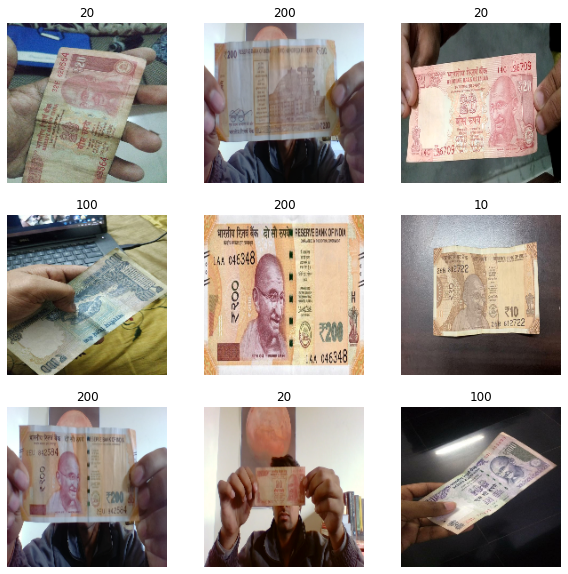

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Creating a batch

In [17]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


## Configuration

In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Rescaling the rgb channels from [0, 255] to [0, 1]

In [19]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [20]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0028860057 1.0


## Creating the model

In [21]:
num_classes = 4

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compiling the model

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

## Training

In [24]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
14/14 [==============================] - 7s 493ms/step - loss: 1.3468 - accuracy: 0.3933 - val_loss: 1.1101 - val_accuracy: 0.5045
Epoch 2/10
14/14 [==============================] - 5s 341ms/step - loss: 0.8527 - accuracy: 0.6584 - val_loss: 0.7282 - val_accuracy: 0.6757
Epoch 3/10
14/14 [==============================] - 5s 352ms/step - loss: 0.5009 - accuracy: 0.8022 - val_loss: 0.6026 - val_accuracy: 0.7027
Epoch 4/10
14/14 [==============================] - 5s 383ms/step - loss: 0.3507 - accuracy: 0.8697 - val_loss: 0.3949 - val_accuracy: 0.8108
Epoch 5/10
14/14 [==============================] - 5s 325ms/step - loss: 0.1965 - accuracy: 0.9258 - val_loss: 0.5406 - val_accuracy: 0.7838
Epoch 6/10
14/14 [==============================] - 7s 489ms/step - loss: 0.1350 - accuracy: 0.9573 - val_loss: 0.3937 - val_accuracy: 0.8559
Epoch 7/10
14/14 [==============================] - 6s 456ms/step - loss: 0.0913 - accuracy: 0.9685 - val_loss: 0.7480 - val_accuracy: 0.7658
Epoch 

## Training results

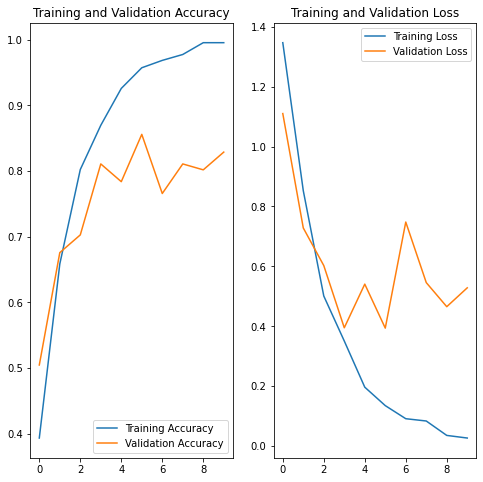

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Augmenting the dataset to improvise for small training samples

In [26]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

### Few augmentaiton examples

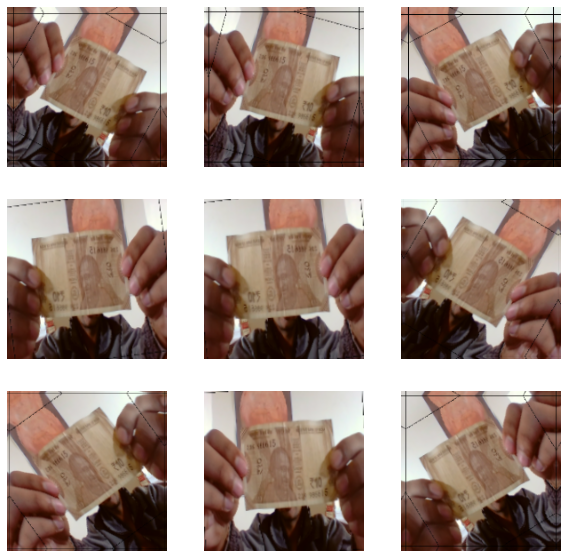

In [27]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Using Dropout to reduce overfitting of the model

In [28]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compiling the model

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

## Training the model

In [31]:
epochs = 200
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/200
14/14 [==============================] - 7s 480ms/step - loss: 1.6310 - accuracy: 0.2764 - val_loss: 1.3049 - val_accuracy: 0.5045
Epoch 2/200
14/14 [==============================] - 7s 517ms/step - loss: 1.1910 - accuracy: 0.4854 - val_loss: 1.1365 - val_accuracy: 0.4955
Epoch 3/200
14/14 [==============================] - 7s 529ms/step - loss: 0.9534 - accuracy: 0.5730 - val_loss: 0.9248 - val_accuracy: 0.6126
Epoch 4/200
14/14 [==============================] - 8s 552ms/step - loss: 0.8830 - accuracy: 0.6247 - val_loss: 0.8808 - val_accuracy: 0.6667
Epoch 5/200
14/14 [==============================] - 7s 508ms/step - loss: 0.9092 - accuracy: 0.5865 - val_loss: 0.8224 - val_accuracy: 0.6396
Epoch 6/200
14/14 [==============================] - 7s 501ms/step - loss: 0.8178 - accuracy: 0.6584 - val_loss: 0.8861 - val_accuracy: 0.6126
Epoch 7/200
14/14 [==============================] - 6s 440ms/step - loss: 0.7533 - accuracy: 0.6787 - val_loss: 0.7222 - val_accuracy: 0.7297

Epoch 58/200
14/14 [==============================] - 7s 533ms/step - loss: 0.0415 - accuracy: 0.9910 - val_loss: 0.3754 - val_accuracy: 0.9099
Epoch 59/200
14/14 [==============================] - 8s 568ms/step - loss: 0.0292 - accuracy: 0.9910 - val_loss: 0.3162 - val_accuracy: 0.9009
Epoch 60/200
14/14 [==============================] - 8s 548ms/step - loss: 0.0335 - accuracy: 0.9910 - val_loss: 0.3700 - val_accuracy: 0.9009
Epoch 61/200
14/14 [==============================] - 7s 524ms/step - loss: 0.1186 - accuracy: 0.9596 - val_loss: 0.4593 - val_accuracy: 0.9009
Epoch 62/200
14/14 [==============================] - 8s 555ms/step - loss: 0.0658 - accuracy: 0.9753 - val_loss: 0.2649 - val_accuracy: 0.9189
Epoch 63/200
14/14 [==============================] - 7s 535ms/step - loss: 0.0668 - accuracy: 0.9775 - val_loss: 0.2900 - val_accuracy: 0.9099
Epoch 64/200
14/14 [==============================] - 7s 532ms/step - loss: 0.0582 - accuracy: 0.9820 - val_loss: 0.3619 - val_accuracy:

Epoch 115/200
14/14 [==============================] - 7s 506ms/step - loss: 0.0094 - accuracy: 0.9978 - val_loss: 0.3853 - val_accuracy: 0.9099
Epoch 116/200
14/14 [==============================] - 7s 500ms/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.4313 - val_accuracy: 0.9279
Epoch 117/200
14/14 [==============================] - 7s 473ms/step - loss: 0.0068 - accuracy: 0.9978 - val_loss: 0.4605 - val_accuracy: 0.9279
Epoch 118/200
14/14 [==============================] - 7s 516ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.4145 - val_accuracy: 0.9189
Epoch 119/200
14/14 [==============================] - 7s 520ms/step - loss: 0.0191 - accuracy: 0.9933 - val_loss: 0.3915 - val_accuracy: 0.9189
Epoch 120/200
14/14 [==============================] - 7s 531ms/step - loss: 0.0423 - accuracy: 0.9865 - val_loss: 0.3634 - val_accuracy: 0.8919
Epoch 121/200
14/14 [==============================] - 8s 548ms/step - loss: 0.0269 - accuracy: 0.9933 - val_loss: 0.3940 - val_ac

## Training results

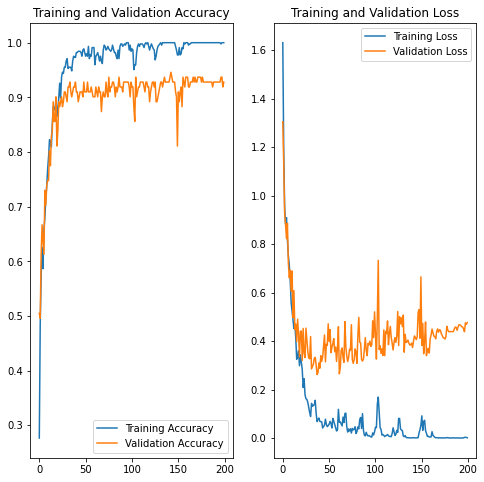

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Testing on new data

In [36]:
test_image_path = '/home/glitch101/Downloads/20_rupee.jpg'

img = keras.preprocessing.image.load_img(
    test_image_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print(score)

This image most likely belongs to 20 with a 100.00 percent confidence.
tf.Tensor([5.7689140e-06 1.9313859e-10 9.9999404e-01 2.7660934e-07], shape=(4,), dtype=float32)


## Saving the model for use with our python script

In [37]:
model.save('/home/glitch101/Downloads/CURRENCY_MODEL/')

INFO:tensorflow:Assets written to: /home/glitch101/Downloads/CURRENCY_MODEL/assets
